# Creating data of density per zone using the dataset of inhabitants per ha in Flanders

This file is used to create an algorithm that calculates the number of inhabitants in a zone. This is done using the following datasets:
* Dataset with population density per ha for whole of Flanders (source: https://www.vlaanderen.be/datavindplaats/catalogus/inwonersdichtheid-per-ha-vlaanderen-toestand-2019)
* Dataset with the zones "ZONERING_spm_VLA.shp" (source: data of MOW)

Since these datasets are for the whole of Flanders, they can be used to calculate the population for any zone in Flanders of the ZONERING_spm_VLA dataset.

# Read data

In [4]:
import pandas as pd
import geopandas as gpd

In [5]:
zones_city = gpd.read_file("Data Antwerpen/ZONERING_spm_VLA/ZONERING_spm_VLA.shp")

In [6]:
# Data from: https://www.vlaanderen.be/datavindplaats/catalogus/inwonersdichtheid-per-ha-vlaanderen-toestand-2019 

inw_per_ha = gpd.read_file("Data_density/inw_per_ha/inw_per_ha2019.shp")
inw_per_ha  # Data contains the number of inhabitants per ha and the coordinates of the ha as a polygon

,DN,geometry
0,4,"POLYGON ((178000.000 244000.000, 178100.000 24..."
1,12,"POLYGON ((178100.000 244000.000, 178200.000 24..."
2,10,"POLYGON ((178400.000 244000.000, 178500.000 24..."
3,3,"POLYGON ((177800.000 243900.000, 177900.000 24..."
4,7,"POLYGON ((178000.000 243900.000, 178100.000 24..."
...,...,...
353358,3,"POLYGON ((122000.000 153500.000, 122100.000 15..."
353359,3,"POLYGON ((123300.000 153500.000, 123500.000 15..."
353360,3,"POLYGON ((120900.000 153400.000, 121000.000 15..."
353361,2,"POLYGON ((122200.000 153400.000, 122400.000 15..."


## Statistics data

In [6]:
# No negative values in the dataset, so no adaptions need to be made 
inw_per_ha['DN'].describe()

count    353363.000000
mean         17.974927
std          25.205639
min           0.000000
25%           4.000000
50%          10.000000
75%          23.000000
max         762.000000
Name: DN, dtype: float64

In [7]:
# Both datasets have the same crs (coordinate reference system), so nothing have to be transformed
print(zones_city.crs)
print(inw_per_ha.crs)

EPSG:31370
EPSG:31370


## Plot data

This plot gives an insight how the data looks on a map. Only the first 100 000 rows of the dataset are showed due to the computation time. These rows shows that this is indeed the same map like in the link below. So if you want to see the full map, use that link.

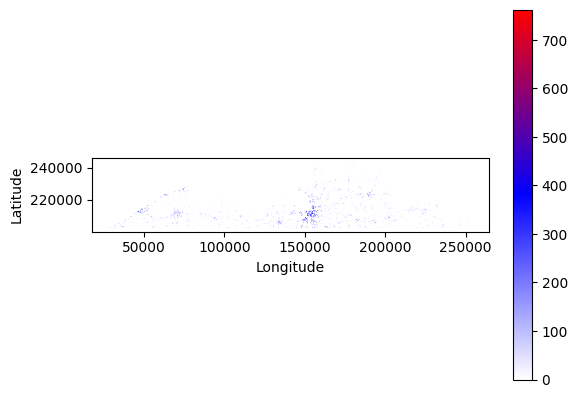

In [17]:
# Full map: see https://www.geopunt.be/?service=https%3A%2F%2Fwww.mercator.vlaanderen.be%2Fraadpleegdienstenmercatorpubliek%2Fows%3Flayers%3Dni%3Ani_inw_ha_vlaa_2019

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the colormap
colors = [(1, 1, 1), (0, 0, 1), (1, 0, 0)]  # White to Blue to Red

# Create the colormap
cmap_name = 'white_blue_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Plot the data using the defined colormap
inw_per_ha[:100000].plot(column='DN', cmap=cm, legend=True)  # only first 100 000 rows are printed to limit the computation time, full map can be seen on the link above

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

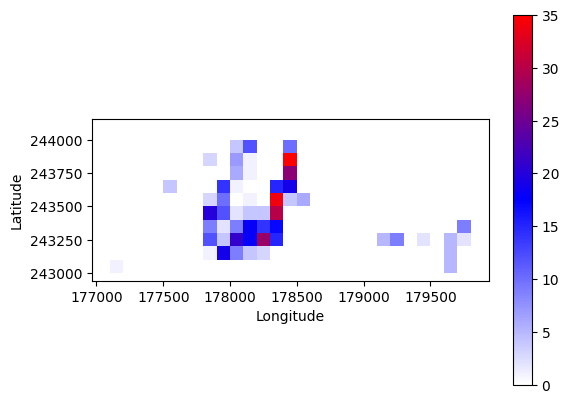

In [18]:
# This plot shows that the data is available per ha, so this is a raster structure

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colormap
colors = [(1, 1, 1), (0, 0, 1), (1, 0, 0)]  # White to Blue to Red
cmap_name = 'white_blue_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Plot the data using the defined colormap
inw_per_ha[:50].plot(column='DN', cmap=cm, legend=True)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

# Calculate inhabitants per zone

The fucntion below calculates the inhabitants per zone.

In [7]:
# Function to calculate the information for the inhabitants per zone

def get_density_info(zones_specific_city):
    percentages = []
    inhabitants = []
    densities = []
    counts = []

    for _, zone in zones_specific_city.iterrows():
        total_percentage_zone = 0  # To keep track of how much of the polygon is covered by the information of inw_per_ha
        inhabits_zone = 0
        count_zone = 0

        for idx, row_ha in inw_per_ha.iterrows():
            intersection = zone['geometry'].intersection(row_ha['geometry'])  # Get the intersection polygon
            
            # If there is an intersection:
            if not intersection.is_empty: 
                area_intersection = intersection.area   
                intersection_percentage_ha = area_intersection / row_ha['geometry'].area * 100
                intersection_percentage_zone = area_intersection / zone['geometry'].area * 100

                total_percentage_zone += intersection_percentage_zone
                inhabits_zone += (intersection_percentage_ha/100)*row_ha['DN']  # Only use the proportion of the ha that is in the zone
                count_zone += 1

        percentages.append(total_percentage_zone)
        inhabitants.append(inhabits_zone)
        counts.append(count_zone)
        area_zone = zone['geometry'].area/1000000  # convert m^2 to km^2
        density_zone = inhabits_zone/area_zone
        densities.append(density_zone)
        
        print('ZONENUMMER: ', zone['ZONENUMMER'])
        print('    percentage: ', total_percentage_zone)
        print('    inhabitants: ', inhabits_zone)
        print('    density: ', density_zone)  
        print('    count: ', count_zone)

    return percentages, inhabitants, densities, counts


The function below makes a panda dataframe for a given city and saved it as a shp file

In [8]:
def make_pd_df_with_info_density_zone(name_city_capital_letters):
    zones_specific_city = zones_city[zones_city["NIS_GEM_L"].str.contains(name_city_capital_letters)]
    print('Numbers of zones: ', len(zones_specific_city))
    percentages, inhabitants, densities, counts = get_density_info(zones_specific_city)

    data_with_density = zones_specific_city[['ZONENUMMER', 'geometry']]
    data_with_density['percentage'] = percentages
    data_with_density['inhabitants'] = inhabitants
    data_with_density['density'] = densities
    data_with_density['count'] = counts

    name_file = "data_density_" + name_city_capital_letters + '.shp'
    data_with_density.to_file(name_file)

# Make datasets for all the cities

In the code below, the panda dataframes are made for 10 cities. Note that the 'percentage' for a zone is always approximately 100%, which means that all the ha of the zones are known.

In [9]:
make_pd_df_with_info_density_zone("ANTWERPEN")

Numbers of zones:  193
ZONENUMMER:  8
    percentage:  99.9999999999998
    inhabitants:  2852.592124257315
    density:  10338.533006786756
    count:  36
ZONENUMMER:  9
    percentage:  100.00000000000021
    inhabitants:  1663.2066651327882
    density:  12061.589961671352
    count:  25
ZONENUMMER:  10
    percentage:  100.00000000000006
    inhabitants:  540.996256043285
    density:  4973.824681225251
    count:  20
ZONENUMMER:  11
    percentage:  100.00000000000036
    inhabitants:  1118.2532638586383
    density:  12097.422043905557
    count:  20
ZONENUMMER:  12
    percentage:  99.9999999999996
    inhabitants:  1353.7625079711872
    density:  9070.17727657951
    count:  28
ZONENUMMER:  13
    percentage:  99.9999999999998
    inhabitants:  1740.4297917775152
    density:  12909.854007569236
    count:  24
ZONENUMMER:  14
    percentage:  99.99999999999991
    inhabitants:  4571.924832143914
    density:  12866.028034818992
    count:  42
ZONENUMMER:  15
    percentage:  1

C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [7]:
make_pd_df_with_info_density_zone("GENT")

Numbers of zones:  116
ZONENUMMER:  2467
    percentage:  100.00000000000034
    inhabitants:  804.273060443415
    density:  3954.6918679301093
    count:  36
ZONENUMMER:  2468
    percentage:  100.00000000000009
    inhabitants:  2717.092742595667
    density:  8733.092071974805
    count:  49
ZONENUMMER:  2469
    percentage:  99.99999999999967
    inhabitants:  1147.8421471494933
    density:  4772.002629029704
    count:  36
ZONENUMMER:  2470
    percentage:  100.00000000000044
    inhabitants:  879.0909432702017
    density:  8459.200304485508
    count:  21
ZONENUMMER:  2471
    percentage:  99.99999999999962
    inhabitants:  2332.2387669003556
    density:  6067.68909368335
    count:  45
ZONENUMMER:  2472
    percentage:  100.00000000000021
    inhabitants:  3021.6032490267808
    density:  8099.5140948242015
    count:  53
ZONENUMMER:  2473
    percentage:  100.0000000000002
    inhabitants:  2726.5542812205617
    density:  9247.141544096277
    count:  44
ZONENUMMER:  2474

C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [ ]:
make_pd_df_with_info_density_zone("MECHELEN")

Numbers of zones:  51
ZONENUMMER:  459
    percentage:  100.00000000000023
    inhabitants:  3464.9046266811883
    density:  7396.536766456062
    count:  69
ZONENUMMER:  460
    percentage:  100.00000000000011
    inhabitants:  2050.697042348451
    density:  7452.452252905987
    count:  36
ZONENUMMER:  461
    percentage:  100.00000000000018
    inhabitants:  1145.6774945242994
    density:  6940.168859814505
    count:  28
ZONENUMMER:  462
    percentage:  99.99999999999966
    inhabitants:  1435.1216669052376
    density:  6488.629398455953
    count:  35
ZONENUMMER:  463
    percentage:  99.99999999999974
    inhabitants:  2674.1114260134045
    density:  10290.45553283578
    count:  42
ZONENUMMER:  464
    percentage:  100.00000000000024
    inhabitants:  2266.34507382914
    density:  7500.4931137287695
    count:  48
ZONENUMMER:  465
    percentage:  100.00000000000017
    inhabitants:  6802.516361652524
    density:  2497.4414538974574
    count:  161
ZONENUMMER:  466
    p

C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [42]:
# Map inhabitants according to the website of the city: https://hasselt.incijfers.be/jive?report=wijkscan&openinputs=true
make_pd_df_with_info_density_zone("HASSELT")

Numbers of zones:  35
ZONENUMMER:  2925
    percentage:  100.00000000000048
    inhabitants:  1291.586055103663
    density:  5064.954625521406
    count:  38
ZONENUMMER:  2926
    percentage:  99.9999999999997
    inhabitants:  1391.2684750373814
    density:  4582.790712122234
    count:  32
ZONENUMMER:  2927
    percentage:  100.00000000000048
    inhabitants:  1480.9062830000764
    density:  3787.8926921492935
    count:  57
ZONENUMMER:  2928
    percentage:  100.00000000000014
    inhabitants:  3165.949337961616
    density:  2577.418525951582
    count:  65
ZONENUMMER:  2929
    percentage:  99.99999999999946
    inhabitants:  1437.3560026720681
    density:  6905.308544381204
    count:  34
ZONENUMMER:  2930
    percentage:  99.99999999999989
    inhabitants:  33.81293838336005
    density:  35.253210581471535
    count:  16
ZONENUMMER:  2931
    percentage:  99.99999999999979
    inhabitants:  3839.4915111510163
    density:  5486.657843571886
    count:  83
ZONENUMMER:  2932


C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [43]:
make_pd_df_with_info_density_zone("SINT-NIKLAAS")

Numbers of zones:  29
ZONENUMMER:  2807
    percentage:  100.0000000000003
    inhabitants:  1548.3638691833246
    density:  4581.507734355522
    count:  47
ZONENUMMER:  2808
    percentage:  99.9999999999996
    inhabitants:  3188.769849166088
    density:  8927.13032793278
    count:  58
ZONENUMMER:  2809
    percentage:  100.00000000000033
    inhabitants:  1532.0709643378912
    density:  8308.105699390935
    count:  31
ZONENUMMER:  2810
    percentage:  100.00000000000031
    inhabitants:  2245.2770156006122
    density:  4464.057396619885
    count:  66
ZONENUMMER:  2811
    percentage:  99.99999999999991
    inhabitants:  2665.7999847137644
    density:  6761.820695160116
    count:  51
ZONENUMMER:  2812
    percentage:  100.00000000000054
    inhabitants:  229.14592111649154
    density:  376.3904311663638
    count:  30
ZONENUMMER:  2813
    percentage:  99.99999999999957
    inhabitants:  4769.8104738806915
    density:  7673.486837121595
    count:  87
ZONENUMMER:  2814
 

C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [38]:
make_pd_df_with_info_density_zone("AALST")

ZONENUMMER:  2151
    percentage:  100.00000000000047
    inhabitants:  916.5429860668633
    density:  4597.109467572739
    count:  32
ZONENUMMER:  2152
    percentage:  99.99999999999956
    inhabitants:  912.9899105877305
    density:  4986.254855320559
    count:  30
ZONENUMMER:  2153
    percentage:  100.00000000000006
    inhabitants:  1082.1187315524098
    density:  6461.308133210553
    count:  28
ZONENUMMER:  2154
    percentage:  100.00000000000003
    inhabitants:  542.748110933622
    density:  3124.657724842371
    count:  14
ZONENUMMER:  2155
    percentage:  100.0000000000001
    inhabitants:  83.81437602869245
    density:  112.70374945666703
    count:  16
ZONENUMMER:  2156
    percentage:  99.99999999999997
    inhabitants:  788.1365163252557
    density:  1025.262625564068
    count:  47
ZONENUMMER:  2157
    percentage:  99.99999999999994
    inhabitants:  1909.6910558620102
    density:  3127.0545118080327
    count:  52
ZONENUMMER:  2158
    percentage:  99.9999

C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [36]:
# Map inhabitants according to the website of the city: https://kortrijk.incijfers.be/dashboard/dashboard/bevolking
make_pd_df_with_info_density_zone("KORTRIJK")

ZONENUMMER:  1830
    percentage:  99.99999999999963
    inhabitants:  1891.6910922224738
    density:  6525.122534983537
    count:  45
ZONENUMMER:  1831
    percentage:  100.00000000000011
    inhabitants:  1221.9406851205438
    density:  3774.325403948387
    count:  51
ZONENUMMER:  1832
    percentage:  100.00000000000011
    inhabitants:  1846.6088766248336
    density:  7504.021523728935
    count:  40
ZONENUMMER:  1833
    percentage:  99.99999999999982
    inhabitants:  856.9728233392269
    density:  4886.73224787411
    count:  30
ZONENUMMER:  1834
    percentage:  100.0
    inhabitants:  4281.92540383778
    density:  7113.075875186928
    count:  86
ZONENUMMER:  1835
    percentage:  100.00000000000018
    inhabitants:  3256.034521078674
    density:  7256.527013676823
    count:  64
ZONENUMMER:  1836
    percentage:  99.99999999999991
    inhabitants:  4807.265776380102
    density:  2482.5256903186496
    count:  156
ZONENUMMER:  1837
    percentage:  99.99999999999994
 

C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [10]:
make_pd_df_with_info_density_zone("HEIST-OP-DEN-BERG")

Numbers of zones:  17
ZONENUMMER:  423
    percentage:  100.00000000000011
    inhabitants:  1901.646572961286
    density:  717.5568779291418
    count:  178
ZONENUMMER:  424
    percentage:  100.00000000000013
    inhabitants:  3003.5941135467106
    density:  1948.188366806536
    count:  175
ZONENUMMER:  425
    percentage:  99.9999999999999
    inhabitants:  3876.196443251713
    density:  2731.8882936421674
    count:  173
ZONENUMMER:  426
    percentage:  100.00000000000021
    inhabitants:  503.3292395343229
    density:  341.23061163650243
    count:  75
ZONENUMMER:  427
    percentage:  99.99999999999999
    inhabitants:  632.4251906983743
    density:  128.73823303016422
    count:  103
ZONENUMMER:  428
    percentage:  100.00000000000004
    inhabitants:  1883.4859422716202
    density:  455.4125792034115
    count:  242
ZONENUMMER:  429
    percentage:  99.99999999999991
    inhabitants:  2356.2453927329984
    density:  461.9770422808278
    count:  309
ZONENUMMER:  430
 

C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [11]:
make_pd_df_with_info_density_zone("LOKEREN")

Numbers of zones:  23
ZONENUMMER:  2776
    percentage:  100.00000000000013
    inhabitants:  2248.924592988363
    density:  6104.064685963403
    count:  57
ZONENUMMER:  2777
    percentage:  100.00000000000007
    inhabitants:  2288.515327399552
    density:  3945.4415938382567
    count:  72
ZONENUMMER:  2778
    percentage:  99.99999999999974
    inhabitants:  4554.16592846394
    density:  3605.8824270264513
    count:  123
ZONENUMMER:  2779
    percentage:  99.99999999999967
    inhabitants:  1384.5560697155995
    density:  6620.4146877909625
    count:  30
ZONENUMMER:  2780
    percentage:  99.99999999999983
    inhabitants:  111.40294894649709
    density:  53.80844223422209
    count:  41
ZONENUMMER:  2781
    percentage:  100.0
    inhabitants:  1951.027386630877
    density:  618.5924566273907
    count:  142
ZONENUMMER:  2782
    percentage:  100.0000000000001
    inhabitants:  2219.9667085786878
    density:  1292.3805597882188
    count:  135
ZONENUMMER:  2783
    perce

C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [12]:
make_pd_df_with_info_density_zone("GEEL")

Numbers of zones:  23
ZONENUMMER:  562
    percentage:  100.00000000000007
    inhabitants:  2449.596110730498
    density:  3639.409003159373
    count:  88
ZONENUMMER:  563
    percentage:  99.99999999999967
    inhabitants:  1248.7461800733333
    density:  3312.8533926820164
    count:  51
ZONENUMMER:  564
    percentage:  100.00000000000003
    inhabitants:  1474.8704106322696
    density:  1456.5521397435073
    count:  98
ZONENUMMER:  565
    percentage:  100.00000000000014
    inhabitants:  689.9850813049043
    density:  186.46346770228527
    count:  101
ZONENUMMER:  566
    percentage:  99.99999999999994
    inhabitants:  3231.1544608822437
    density:  2350.118115994325
    count:  126
ZONENUMMER:  567
    percentage:  99.99999999999994
    inhabitants:  1133.7026566515967
    density:  186.48687011664822
    count:  164
ZONENUMMER:  568
    percentage:  99.99999999999989
    inhabitants:  1247.6860778779744
    density:  195.60232265634568
    count:  149
ZONENUMMER:  569

C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [13]:
make_pd_df_with_info_density_zone("DENDERMONDE")

Numbers of zones:  18
ZONENUMMER:  2293
    percentage:  99.99999999999977
    inhabitants:  1485.29259989352
    density:  4261.193799948344
    count:  49
ZONENUMMER:  2294
    percentage:  99.9999999999997
    inhabitants:  1400.2399672201714
    density:  2927.39913242823
    count:  50
ZONENUMMER:  2295
    percentage:  100.00000000000047
    inhabitants:  1606.3832235846362
    density:  3003.4479943478223
    count:  61
ZONENUMMER:  2296
    percentage:  100.00000000000017
    inhabitants:  928.4319801728495
    density:  2961.1115984646676
    count:  33
ZONENUMMER:  2297
    percentage:  99.99999999999997
    inhabitants:  1564.6448431825443
    density:  1697.0536724146875
    count:  52
ZONENUMMER:  2298
    percentage:  99.99999999999972
    inhabitants:  1960.3633438206555
    density:  2687.6392527794515
    count:  61
ZONENUMMER:  2299
    percentage:  99.99999999999997
    inhabitants:  499.08295228153213
    density:  106.42667811375756
    count:  92
ZONENUMMER:  2300

C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [10]:
make_pd_df_with_info_density_zone("BEVEREN")

Numbers of zones:  48
ZONENUMMER:  2723
    percentage:  99.99999999999972
    inhabitants:  3712.9901167405555
    density:  4020.8059136549355
    count:  95
ZONENUMMER:  2724
    percentage:  99.99999999999984
    inhabitants:  1815.460890437415
    density:  5041.470294201853
    count:  51
ZONENUMMER:  2725
    percentage:  100.00000000000054
    inhabitants:  498.8838915757208
    density:  1057.719352570082
    count:  37
ZONENUMMER:  2726
    percentage:  100.00000000000009
    inhabitants:  1226.8796776326096
    density:  244.73201182134923
    count:  142
ZONENUMMER:  2727
    percentage:  100.00000000000053
    inhabitants:  2176.036812842526
    density:  1987.7139311218202
    count:  83
ZONENUMMER:  2728
    percentage:  100.00000000000027
    inhabitants:  1850.2638069395482
    density:  4598.584443689433
    count:  57
ZONENUMMER:  2729
    percentage:  99.99999999999974
    inhabitants:  2075.701538542134
    density:  1528.930889318407
    count:  121
ZONENUMMER:  2

C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emmad\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro